<a href="https://colab.research.google.com/github/RedDawe/Whales/blob/master/humping_whales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

triplet loss: https://github.com/omoindrot/tensorflow-triplet-loss

bounding box model: https://www.kaggle.com/martinpiotte/bounding-box-model

Higher accuracy could be achieved with bigger network trained longer and better manual preprocessing, as the dataset has issues.

In [0]:
!pip install tensorflow-gpu==2.1

     |████████████████████████████████| 421.8MB 20kB/s 
     |████████████████████████████████| 3.9MB 35.7MB/s 
     |████████████████████████████████| 450kB 34.8MB/s 
ERROR: tensorflow 1.15.0 has requirement tensorboard<1.16.0,>=1.15.0, but you'll have tensorboard 2.1.1 which is incompatible.
ERROR: tensorflow 1.15.0 has requirement tensorflow-estimator==1.15.1, but you'll have tensorflow-estimator 2.1.0 which is incompatible.
ERROR: tensorflow-federated 0.12.0 has requirement tensorflow~=2.1.0, but you'll have tensorflow 1.15.0 which is incompatible.
ERROR: tensorflow-federated 0.12.0 has requirement tensorflow-addons~=0.7.0, but you'll have tensorflow-addons 0.8.3 which is incompatible.
  Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
      Successfully uninstalled tensorboard-1.15.0
  Found existing installation: tensorflow-estimator 1.15.1
    Uninstalling tensorflow-estimator-1.15.1:
      Successfully uninstalled tensorflow-estimator-1.15.1


In [0]:
!pip install --upgrade --force-reinstall --no-deps kaggle

Processing /root/.cache/pip/wheels/57/4e/e8/bb28d035162fb8f17f8ca5d42c3230e284c6aa565b42b72674/kaggle-1.5.6-cp36-none-any.whl
  Found existing installation: kaggle 1.5.6
    Uninstalling kaggle-1.5.6:
      Successfully uninstalled kaggle-1.5.6


In [0]:
#!pip install -q --no-deps tensorflow-addons~=0.7

In [0]:
#!pip install typeguard

In [0]:
from google.colab import files
files.upload()

In [0]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c humpback-whale-identification
!unzip humpback-whale-identification.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/cd310f07c.jpg     
  inflating: train/cd32697ae.jpg     
  inflating: train/cd346388a.jpg     
  inflating: train/cd36f1901.jpg     
  inflating: train/cd382b662.jpg     
  inflating: train/cd3937f27.jpg     
  inflating: train/cd3a073a2.jpg     
  inflating: train/cd3afe416.jpg     
  inflating: train/cd407fae0.jpg     
  inflating: train/cd437a15c.jpg     
  inflating: train/cd444321e.jpg     
  inflating: train/cd4740ee9.jpg     
  inflating: train/cd49e7801.jpg     
  inflating: train/cd4b8f33f.jpg     
  inflating: train/cd4fae084.jpg     
  inflating: train/cd520d861.jpg     
  inflating: train/cd52c565c.jpg     
  inflating: train/cd5577b32.jpg     
  inflating: train/cd5712905.jpg     
  inflating: train/cd598b557.jpg     
  inflating: train/cd59d5874.jpg     
  inflating: train/cd5a9c5b1.jpg     
  inflating: train/cd5b23ddc.jpg     
  inflating: train/cd5dd712e.jpg     
  inflating: train/cd610ea95.jpg     

In [0]:
import tensorflow as tf
print(tf.__version__)
#assert tf.executing_eagerly()
import numpy as np
import pandas as pd
import cv2
import os
from google.colab.patches import cv2_imshow
from sklearn.preprocessing import LabelEncoder
#import tensorflow_addons as tfa
from triplet_loss import batch_hard_triplet_loss
import csv

2.1.0


In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
dimensions = (224, 224) #(331, 331)

In [0]:
files = os.listdir('test')

(600, 1050, 3)


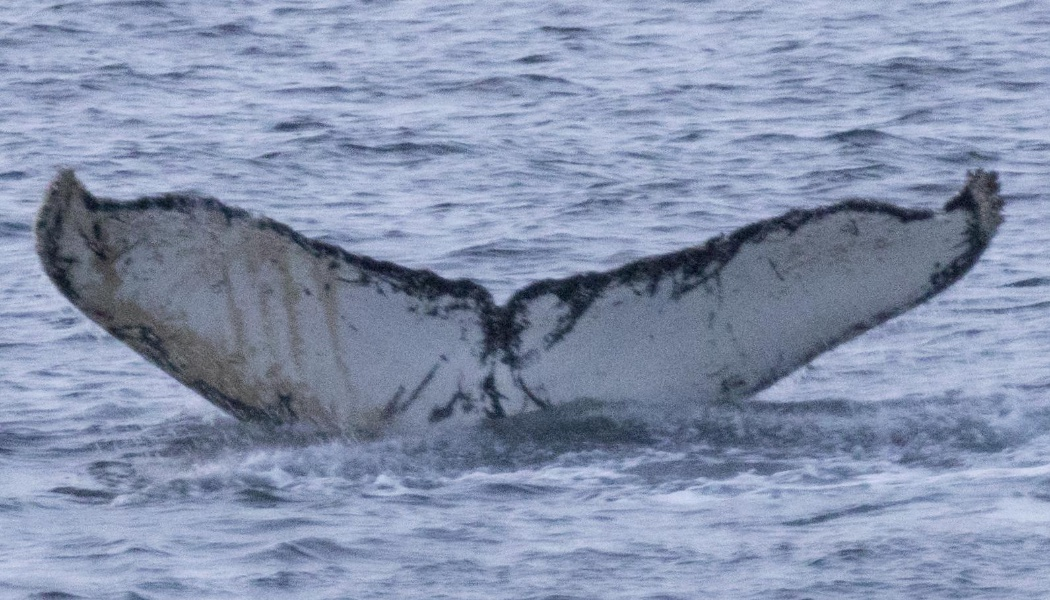

In [0]:
img = cv2.imread('test/' + files[33])
print(img.shape)
cv2_imshow(img)

In [0]:
cropping_model = tf.keras.models.load_model('cropping.model')

In [0]:
def load_image(file_name, base_path = 'train/'):
  try:
    img = cv2.imread(base_path + file_name)
    small_greyscale = cv2.resize(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY), (128, 128))
    bbox = (cropping_model.predict(small_greyscale.reshape(1, 128, 128, 1))[0, :]/128*dimensions[0]).astype(np.int32)

    bbox[[0, 2]] = np.sort(bbox[[0, 2]])
    bbox[[1, 3]] = np.sort(bbox[[1, 3]])
    bbox[3] = bbox[3] + (0 if bbox[1] > 0 else np.abs(bbox[1]))
    bbox[2] = bbox[2] + (0 if bbox[0] > 0 else np.abs(bbox[0]))
    bbox = np.maximum(bbox, 0)

    img = cv2.resize(img, dimensions)
    img = img[bbox[1]:bbox[3], bbox[0]:bbox[2]]

    #final_img = np.zeros([224, 224, 3], np.float32)
    #final_img[:img.shape[0], :img.shape[1]] = img

    final_img = cv2.resize(img, dimensions)

    return (final_img/255).astype(np.float32)
  except:
    return _load_image(file_name, base_path)

In [0]:
ids = pd.read_csv('train.csv')
ids.head(10)

,Image,Id
0,0000e88ab.jpg,w_f48451c
1,0001f9222.jpg,w_c3d896a
2,00029d126.jpg,w_20df2c5
3,00050a15a.jpg,new_whale
4,0005c1ef8.jpg,new_whale
5,0006e997e.jpg,new_whale
6,000a6daec.jpg,w_dd88965
7,000f0f2bf.jpg,new_whale
8,0016b897a.jpg,w_64404ac
9,001c1ac5f.jpg,w_a6f9d33


In [0]:
ids = ids[ids['Id'] != 'new_whale']
ids.head(10)

,Image,Id
0,0000e88ab.jpg,w_f48451c
1,0001f9222.jpg,w_c3d896a
2,00029d126.jpg,w_20df2c5
6,000a6daec.jpg,w_dd88965
8,0016b897a.jpg,w_64404ac
9,001c1ac5f.jpg,w_a6f9d33
10,001cae55b.jpg,w_581ba42
16,00355ff28.jpg,w_cb622a2
17,00357e37a.jpg,w_d3b46e7
21,00442c882.jpg,w_8cad422


In [0]:
le = LabelEncoder()
y = le.fit_transform(ids['Id'])
y[0:5]

array([4785, 3807,  661, 4314, 1928])

In [0]:
sorter = np.argsort(y)
sorter

array([ 8002,  2870, 12090, ...,  9641, 12995, 13721])

In [0]:
y = y[sorter]

In [0]:
ids = ids.iloc[sorter]

In [0]:
def _load_image(file_name, base_path = 'train/'):
  return (cv2.resize(cv2.imread(base_path + file_name), dimensions)/255).astype(np.float32)

In [0]:
x = np.zeros([ids.size//2, dimensions[0], dimensions[1], 3], dtype=np.float32)
for i, file_name in enumerate(ids['Image']):
  x[i, :, :, :] = load_image(file_name)

In [0]:
y.shape

(15697,)

In [0]:
x.shape

(15697, 224, 224, 3)

In [0]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    #featurewise_center=True,
    #featurewise_std_normalization=True,
    brightness_range=[0.8, 1.2],
    shear_range=0.1,
    zoom_range=0.1,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
    )

In [0]:
datagen.fit(x[:int(x.shape[0]*0.8)])

In [0]:
# adding dropout into VGG16 is simple, not so much into DenseNet, therefore only image augmentation is used

net = tf.keras.applications.VGG16(include_top=False, pooling='avg')

model = tf.keras.models.Sequential()
first = True
for layer in net.layers:
  model.add(layer)
  if isinstance(layer, tf.keras.layers.Conv2D):
    if not first:
      model.add(tf.keras.layers.Dropout(0.2))
    else:
      first = False

model.add(tf.keras.layers.Dense(128, activation=None))
model.add(tf.keras.layers.Lambda(lambda a: tf.math.l2_normalize(a, axis=1)))

model.summary()

In [0]:
net = tf.keras.applications.DenseNet121(include_top=False, pooling='avg')

29089792/29084464 [==============================] - 0s 0us/step


In [0]:
net.summary()

Model: "densenet121"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D (None, None, None, 3 0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, None, None, 6 9408        zero_padding2d_2[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, None, None, 6 256         conv1/conv[0][0]                 
________________________________________________________________________________________

In [0]:
def transition_block(a, i, net):
  a = net.layers[i](a)
  a = net.layers[i+1](a)
  a = net.layers[i+2](a)
  a = tf.keras.layers.Dropout(0.2)(a)
  a = net.layers[i+3](a)

  return a, i+4

In [0]:
def conv_block(a, i, net):
  a1 = net.layers[i](a)
  a1 = net.layers[i+1](a1)
  a1 = net.layers[i+2](a1)
  a1 = tf.keras.layers.Dropout(0.2)(a1)
  a1 = net.layers[i+3](a1)
  a1 = net.layers[i+4](a1)
  a1 = net.layers[i+5](a1)
  a1 = tf.keras.layers.Dropout(0.2)(a1)
  a = tf.keras.layers.Concatenate()(list([a, a1]))

  return a, i+7

In [0]:
def dense_block(a, i, net, blocks):
  for j in range(blocks):
    a, i = conv_block(a, i, net)
  return a, i

In [0]:
model = net.input
for i in range(1, 7):
  model = net.layers[i](model)
model, i = dense_block(model, 7, net, 6)
model, i = transition_block(model, i, net)
model, i = dense_block(model, i, net, 12)
model, i = transition_block(model, i, net)
model, i = dense_block(model, i, net, 24)
model, i = transition_block(model, i, net)
model, i = dense_block(model, i, net, 16)
for j in range(i, len(net.layers)):
  model = net.layers[j](model)

model = tf.keras.layers.Dense(128, activation=None)(model)
model = tf.keras.layers.Lambda(lambda a: tf.math.l2_normalize(a, axis=1))(model)

In [0]:
model = tf.keras.Model(net.input, model)
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D (None, None, None, 3 0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, None, None, 6 9408        zero_padding2d_2[2][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, None, None, 6 256         conv1/conv[2][0]                 
____________________________________________________________________________________________

In [0]:
net = tf.keras.applications.DenseNet121(include_top=False, pooling='avg')

model = tf.keras.layers.Dense(128, activation=None)(net.output)
model = tf.keras.layers.Lambda(lambda a: tf.math.l2_normalize(a, axis=1))(model)

model = tf.keras.Model(net.input, model)
model.summary()

29089792/29084464 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, None, None, 6 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, None, None, 6 256         conv1/conv[0][0]                 
_____________________________

In [0]:
def triplet_loss(labels, logits):
  return batch_hard_triplet_loss(tf.squeeze(labels, axis=-1), logits, 0.2)

In [0]:
#model.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss=tfa.losses.TripletSemiHardLoss())
#model.compile(optimizer=tf.keras.optimizers.Adam(0.0001), loss=triplet_loss)
model.compile(optimizer=tf.keras.optimizers.Adam(), loss=triplet_loss)

In [0]:
checkpoint_path = "gdrive/My Drive/training_7/cp.ckpt"

#cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, verbose=1, save_best_only=True, monitor='val_loss')
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, verbose=1)

In [0]:
num_epochs = 128
min_lr, max_lr = 0.00001, 0.0001
step_size = 8

def clr_schedule(epoch):
  cycle = tf.math.floor(1 + epoch / (2 * step_size))
  x = tf.math.abs(epoch / step_size - 2 * cycle + 1)
  lr = min_lr + (max_lr - min_lr) * tf.maximum(0, 1 - x)

  return lr

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(clr_schedule)

In [0]:
model.fit(x, y, epochs=num_epochs, batch_size=64, validation_split=0.2, callbacks=[cp_callback, lr_scheduler])#, shuffle=False)

Train on 12557 samples, validate on 3140 samples
Epoch 1/128
12544/12557 [============================>.] - ETA: 0s - loss: 0.0097
Epoch 00001: saving model to gdrive/My Drive/training_7/cp.ckpt
12557/12557 [==============================] - 94s 7ms/sample - loss: 0.0097 - val_loss: 0.0093
Epoch 2/128
12544/12557 [============================>.] - ETA: 0s - loss: 0.0090
Epoch 00002: saving model to gdrive/My Drive/training_7/cp.ckpt
12557/12557 [==============================] - 75s 6ms/sample - loss: 0.0090 - val_loss: 0.0085
Epoch 3/128
12544/12557 [============================>.] - ETA: 0s - loss: 0.0085
Epoch 00003: saving model to gdrive/My Drive/training_7/cp.ckpt
12557/12557 [==============================] - 75s 6ms/sample - loss: 0.0084 - val_loss: 0.0079
Epoch 4/128
12544/12557 [============================>.] - ETA: 0s - loss: 0.0085
Epoch 00004: saving model to gdrive/My Drive/training_7/cp.ckpt
12557/12557 [==============================] - 75s 6ms/sample - loss: 0.0085 - 

In [0]:
#model.fit_generator(datagen.flow(x, y, batch_size=64), steps_per_epoch=int(np.ceil(x.shape[0] / 64)), epochs=num_epochs, callbacks=[cp_callback, lr_scheduler], shuffle=False)

In [0]:
model.fit(datagen.flow(x, y, batch_size=64), steps_per_epoch=int(np.ceil(x.shape[0] / 64)), epochs=num_epochs, callbacks=[cp_callback, lr_scheduler], shuffle=False)

  ...
    to  
  ['...']
Train for 246 steps
Epoch 1/128
245/246 [============================>.] - ETA: 0s - loss: 0.0093
Epoch 00001: saving model to gdrive/My Drive/training_5/cp.ckpt
246/246 [==============================] - 191s 777ms/step - loss: 0.0093
Epoch 2/128
245/246 [============================>.] - ETA: 0s - loss: 0.0085
Epoch 00002: saving model to gdrive/My Drive/training_5/cp.ckpt
246/246 [==============================] - 181s 735ms/step - loss: 0.0085
Epoch 3/128
245/246 [============================>.] - ETA: 0s - loss: 0.0074
Epoch 00003: saving model to gdrive/My Drive/training_5/cp.ckpt
246/246 [==============================] - 180s 730ms/step - loss: 0.0073
Epoch 4/128
245/246 [============================>.] - ETA: 0s - loss: 0.0063
Epoch 00004: saving model to gdrive/My Drive/training_5/cp.ckpt
246/246 [==============================] - 180s 734ms/step - loss: 0.0063
Epoch 5/128
245/246 [============================>.] - ETA: 0s - loss: 0.0055
Epoch 00005: 

KeyboardInterrupt: ignored

In [0]:
model.evaluate(x[int(x.shape[0]*0.8):], y[int(x.shape[0]*0.8):])

3140/3140 [==============================] - 21s 7ms/sample - loss: 0.0965


0.09654694558328884

In [0]:
model.load_weights(checkpoint_path)

In [0]:
ex = model.predict(x)
ex.shape

(15697, 128)

In [0]:
def diff(a, b):
  return np.sqrt(np.sum(np.square(a - b)))

In [0]:
poss = []
negs = []

for i in range(ex.shape[0]):
  putin = False
  for j in range(ex.shape[0]):
    if  y[i] == y[j]:
      poss.append(diff(ex[i], ex[j]))
      putin = False #keep poss and negs roughly the same len
    elif not putin:
      negs.append(diff(ex[i], ex[j]))
      putin = True

In [0]:
pd.DataFrame(poss).describe()

,0
count,155571.000000
mean,0.453149
std,0.238147
min,0.000000
25%,0.325954
50%,0.448405
75%,0.584663
max,1.494721


In [0]:
pd.DataFrame(negs).describe()

,0
count,171092.000000
mean,1.271128
std,0.159945
min,0.423764
25%,1.177193
50%,1.290157
75%,1.384056
max,1.736792


In [0]:
for i in range(1, 21, 1):
  print(np.mean(np.where(np.array(poss) < i/10, 1, 0)), np.mean(np.where(np.array(negs) > i/10, 1, 0)), i/10, np.mean(np.where(np.array(poss) < i/10, 1, 0))* np.mean(np.where(np.array(negs) > i/10, 1, 0)))

0.10092497959131201 1.0 0.1 0.10092497959131201
0.11429508070270165 1.0 0.2 0.11429508070270165
0.2084643024728259 1.0 0.3 0.2084643024728259
0.39496435711025835 1.0 0.4 0.39496435711025835
0.6072404239864756 0.9999590863395132 0.5 0.6072155795579348
0.771371270995237 0.999672690716106 0.6 0.7711187940169111
0.8685744772483304 0.998334229537325 0.7 0.8671276315394967
0.9256802360337081 0.9928576438407406 0.8 0.919068698098368
0.9602239491936158 0.9762817665349637 0.9 0.9374491333879224
0.9800476952645416 0.9356720360975381 1.0 0.9170032225008732
0.9911680197466108 0.8583919762466977 1.1 0.8508106752628192
0.9965032043247135 0.7084492553713791 1.2 0.7059719530790366
0.9991643686805382 0.4742419283192668 1.3 0.47384563691096127
0.9999614324006402 0.21140088373506652 1.4 0.2113927305104783
1.0 0.050715404577654125 1.5 0.050715404577654125
1.0 0.004886260023846819 1.6 0.004886260023846819
1.0 5.260327776868585e-05 1.7 5.260327776868585e-05
1.0 0.0 1.8 0.0
1.0 0.0 1.9 0.0
1.0 0.0 2.0 0.0


In [0]:
for j in range(1, 11, 1):
  i = 8 + j/10
  print(np.mean(np.where(np.array(poss) < i/10, 1, 0)), np.mean(np.where(np.array(negs) > i/10, 1, 0)), i/10, np.mean(np.where(np.array(poss) < i/10, 1, 0))* np.mean(np.where(np.array(negs) > i/10, 1, 0)))

0.9302569244910683 0.9918523367544947 0.8099999999999999 0.9226775043385157
0.9344093693554711 0.9907125990695065 0.82 0.9257311349090572
0.938021867828837 0.9895085684894677 0.8300000000000001 0.9281806756471291
0.9416986456344691 0.9880298319033035 0.8400000000000001 0.9304263545497932
0.9450797385116764 0.9865277160825755 0.85 0.9323473559498417
0.9481265788610987 0.9849554625581558 0.86 0.9338624530458153
0.9513276896079603 0.9829799172375097 0.8699999999999999 0.9351360135965842
0.954335962358023 0.9810569751946321 0.8800000000000001 0.9362579525504203
0.9572285323100064 0.9788008790592196 0.89 0.9369361288856008
0.9602239491936158 0.9762817665349637 0.9 0.9374491333879224


In [0]:
poss = []
negs = []

for i in range(int(ex.shape[0]*0.8), ex.shape[0]):
  putin = False
  for j in range(ex.shape[0]):
    if  y[i] == y[j]:
      poss.append(diff(ex[i], ex[j]))
      putin = False #keep poss and negs roughly the same len
    elif not putin:
      negs.append(diff(ex[i], ex[j]))
      putin = True

In [0]:
pd.DataFrame(poss).describe()

,0
count,32373.000000
mean,0.485785
std,0.257095
min,0.000000
25%,0.339340
50%,0.477307
75%,0.635361
max,1.398391


In [0]:
pd.DataFrame(negs).describe()

,0
count,35472.000000
mean,1.268859
std,0.160112
min,0.423764
25%,1.174628
50%,1.288521
75%,1.382271
max,1.736792


In [0]:
for i in range(1, 21, 1):
  print(np.mean(np.where(np.array(poss) < i/10, 1, 0)), np.mean(np.where(np.array(negs) > i/10, 1, 0)), i/10, np.mean(np.where(np.array(poss) < i/10, 1, 0))* np.mean(np.where(np.array(negs) > i/10, 1, 0)))

0.09699440892101442 1.0 0.1 0.09699440892101442
0.10931949464059555 1.0 0.2 0.10931949464059555
0.19556420473851666 1.0 0.3 0.19556420473851666
0.3542767120748772 1.0 0.4 0.3542767120748772
0.5435393692274426 0.9999154262516915 0.5 0.5434934000656338
0.7054335402959256 0.9996335137573297 0.6 0.705175008608289
0.8169153306767986 0.9982521425349572 0.7 0.8154874791177672
0.8878695208970439 0.9926984663960307 0.8 0.881386711754274
0.9384672412195348 0.976319350473613 0.9 0.9162437273882197
0.9678126834090137 0.9343989625620207 1.0 0.9043231673317478
0.9857906279924629 0.8551251691474966 1.1 0.8429743775060717
0.9941926914403979 0.7044993234100135 1.2 0.7004080784589407
0.9991350817038891 0.46890505187189896 1.3 0.46849948731339613
1.0 0.20740302210193956 1.4 0.20740302210193956
1.0 0.049588407758231846 1.5 0.049588407758231846
1.0 0.004538791159224177 1.6 0.004538791159224177
1.0 2.819124943617501e-05 1.7 2.819124943617501e-05
1.0 0.0 1.8 0.0
1.0 0.0 1.9 0.0
1.0 0.0 2.0 0.0


In [0]:
for j in range(1, 11, 1):
  i = 9 + j/10
  print(np.mean(np.where(np.array(poss) < i/10, 1, 0)), np.mean(np.where(np.array(negs) > i/10, 1, 0)), i/10, np.mean(np.where(np.array(poss) < i/10, 1, 0))* np.mean(np.where(np.array(negs) > i/10, 1, 0)))

0.9424520433694745 0.9737257555254849 0.9099999999999999 0.9176898279764787
0.9460043863713589 0.971160351826793 0.9199999999999999 0.9187219526980982
0.9487535909554258 0.9677492106450157 0.93 0.9181555387437375
0.9521205943224292 0.964084348218313 0.9400000000000001 0.917924562602572
0.9551786982979643 0.9605886332882273 0.95 0.9175338003440695
0.9580205726994718 0.9561062246278755 0.96 0.9159694328795271
0.9606771074660982 0.9512291384754172 0.97 0.9138240572880324
0.9632718623544312 0.9463802435723951 0.9800000000000001 0.9116214597214213
0.966051956877645 0.9406574199368516 0.99 0.9087239412814722
0.9678126834090137 0.9343989625620207 1.0 0.9043231673317478


I keep reusing var name 'x' to save RAM

In [0]:
x = np.zeros([len(files), dimensions[0], dimensions[1], 3], dtype=np.float32)
for i, file_name in enumerate(files):
  x[i, :, :, :] = load_image(file_name, 'test/')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in int_scalars
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in int_scalars
  # Remove the CWD from sys.path while we load stuff.


In [0]:
x = model.predict(x)

In [0]:
preds = np.zeros([x.shape[0], 5])
for i in range(x.shape[0]):
  pred = np.ones([5, 2]) * 0.91

  min_ind = np.argmax(pred[:, 1])
  for j in range(ex.shape[0]):
    difference = diff(x[i], ex[j])

    if difference < pred[min_ind, 1]:
      for k in range(pred.shape[0]):
        if pred[k, 0] == y[j]:
          pred[k, 1] = np.min([difference, pred[k, 1]])
          break
      else:
        pred[min_ind, :] = [y[j], difference]
      min_ind = np.argmax(pred[:, 1])

  #pred[min_ind, 0] = 0.51
  pred = pred[np.argsort(pred[:, 1]), :]
  preds[i, :] = pred[:, 0]

In [0]:
with open('submission.csv', 'w', newline='') as f:
  writer = csv.writer(f)

  writer.writerow(['Image', 'Id'])
  for i in range(preds.shape[0]):
    quintet = ''
    for j in range(preds.shape[1]):
      if  preds[i, j] == 0.51:
        quintet += 'new_whale'
      else:
        quintet += le.inverse_transform([int(preds[i, j])])[0]
      if j + 1 < preds.shape[1]:
        quintet += ' '

    writer.writerow([files[i], quintet])